# CS109A - Final Project

# Canvas Group - Final Project # 150

# Group Members - Akhil Srivastava, Han Truong, Yuying Qian

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from arch import arch_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

verbose = False

# Used to parse 'Date Time' column values as pandas DatetimeIndex
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

# Setup Data Pipeline

### Functions to Read and Scale the Data

In [20]:
# Reads Data Downloaded from Yahoo!
def read_yahoo_data(file_name):
    # Read the file and parse 'Date' column values as pandas DatetimeIndex
    df = pd.read_csv(file_name, parse_dates=['Date'], date_parser=dateparse)

    # Set 'Date' column as index
    df.set_index('Date', inplace=True)

    # Drop 'Adj Close' and 'Volume' columns as they are not needed
    df = df.drop(['Adj Close', 'Volume'], 1) 
    
    return df

# Reads Data Downloaded from Bloomberg
def read_bloomberg_data(file_name):
    # Read the file and parse 'DATE' column values as pandas DatetimeIndex
    df = pd.read_csv(file_name, parse_dates=['DATE'], date_parser=dateparse)
    
    df.columns = ['Date','Open','High','Low','Close','Volume']

    # Set 'Date' column as index
    df.set_index('Date', inplace=True)

    # Drop 'Volume' columns as they are not needed
    df = df.drop(['Volume'], 1)
    
    return df

def perform_scaling(df):    
     # Create a new dataframe for the scaled values
    df_scaled = df.copy()

    # Dictionary to save the MinMaxScaler scalar objects used for the price transformation
    scalers = {}

    # Scale the data
    for column in df_scaled.columns:
        # Create a new MinMaxScaler scalar object 
        scaler = MinMaxScaler(feature_range = (0, 1))

        # Apply the transformaion on current column
        df_scaled[column] = scaler.fit_transform(df_scaled[[column]])

        # Save the MinMaxScaler object used for price for reverse transformation later
        scalers[column] = scaler
            
    return df_scaled, scalers

### Specify Security Names, Data Dir Name, File Names and Data Reader Function

In [21]:
yahoo_security_list = ['Apple Stock', 'Amazon Stock', 'Microsoft Stock', 'S&P 500 Index', 'Nasdaq 100 Index']
yahoo_data_dir = './yahoo_full_data/'
yahoo_file_list = ['AAPL.csv', 'AMZN.csv', 'MSFT.csv', '^GSPC.csv', '^IXIC.csv']

#bloomberg_security_list = ['Apple Stock', 'Microsoft Stock', 'S&P 500 Index', 'Nasdaq 100 Index']
bloomberg_security_list = ['Apple Stock', 'Nasdaq 100 Index']
bloomberg_data_dir = './data/'
#bloomberg_file_list = ['Apple.csv', 'Microsoft.csv', 'SP500.csv', 'NASDAQ100.csv']
bloomberg_file_list = ['Apple.csv', 'NASDAQ100.csv']

security_list = bloomberg_security_list
data_dir = bloomberg_data_dir
file_list = bloomberg_file_list
data_reader = read_bloomberg_data

# Price type to predict
price_type = "Close"

### Read and Scale the Data

In [22]:
# Dictionaries to store security price, price diff, price diff of log returns, scaled price and scalers
dfs_price = {}
dfs_price_diff = {}
dfs_price_diff_log_return = {}
dfs_price_scaled = {}
scalers = {}

# Display Summary Statistics, Price Charts and ACF & PACF Plots for Price, Price Difference and Log Returns
for i in range(len(security_list)):
    print("Processing", security_list[i], "...")

    df = data_reader(data_dir + file_list[i]).dropna()['2010-01-04':]
    df_diff = df.diff().dropna()
    df_diff_log_returns = np.log(df).diff().dropna()
            
    dfs_price[security_list[i]] = df
    dfs_price_diff[security_list[i]] = df_diff
    dfs_price_diff_log_return[security_list[i]] = df_diff_log_returns
    dfs_price_scaled[security_list[i]], scalers[security_list[i]] = perform_scaling(df)

Processing Apple Stock ...
Processing Nasdaq 100 Index ...


# Exploratory Data Analysis

### Functions to Display Summary Statistics, Price Charts and ACF & PACF Charts

In [23]:
# Displays Summary Statistics and Top and Bottom Rows
def describe_and_peek(df, security_name):
    print("\nNumber of observations:", len(df.index), "\n")    
    print(security_name, "- Summary Statistics\n\n", df.describe(), "\n")
    print(security_name, "- Top Rows\n\n", df.head(3), "\n")
    print(security_name, "- Bottom Rows\n\n", df.tail(3), "\n")

# Displays Price Charts
def display_price_charts(df, security_name, price_type, unit):    
    title =  price_type + security_name + " Daily Price" +  " (in " + unit + ")"
    columns = df.columns.values
    nrows = len(df.columns)//2
    
    fig, ax = plt.subplots(nrows=nrows, ncols=2, sharex=False, figsize=(18, 8*nrows))
    fig.suptitle(title, y=0.95, size=18)
    plt.subplots_adjust(wspace = 0.13, hspace = 0.3)

    for i in range(len(columns)):
        row = i//2
        column = i%2
        
        ax[row, column].plot(df.index, df[columns[i]], "-o", ms='1', color=np.random.rand(3,))
        ax[row, column].set_title(price_type + columns[i] + " Price", fontsize=18)
        ax[row, column].set_xlabel("Date", fontsize=15)
        ax[row, column].grid(True);
        
    plt.show()

# Displays ACF and PACF Charts for all the columns in a dataframe
def plot_acf_pacf_dataframe(df, security_name, price_type):    
    h_max = 30
    title =  "ACF and PACF of " + price_type + security_name + " Daily Price"
    columns = df.columns.values

    fig, ax = plt.subplots(nrows=len(columns), ncols=2, sharex=False, figsize=(18, 8*len(columns)))
    ax = ax.reshape(-1, 2)
    fig.suptitle(title, y=1, size=18)
    plt.subplots_adjust(wspace = 0.13, hspace = 0.3)
    
    for i in range(len(columns)):
        plot_acf(df[columns[i]], ax=ax[i, 0], lags=h_max, color='crimson')
        ax[i, 0].set_xlabel("lag", fontsize=15)
        ax[i, 0].set_ylabel("ACF", fontsize=15)
        ax[i, 0].set_title("ACF - " + price_type + columns[i] + " Price", fontsize=15)
        ax[i, 0].grid(True)

        plot_pacf(df[columns[i]], ax=ax[i, 1], lags=h_max, color='lightseagreen')
        ax[i, 1].set_xlabel("lag", fontsize=15)
        ax[i, 1].set_ylabel("PACF", fontsize=15)
        ax[i, 1].set_title("PACF - " + price_type + columns[i] + " Price", fontsize=15)
        ax[i, 1].grid(True)

    plt.show()
    
# Displays ACF and PACF Charts of Residuals
def plot_acf_pacf(data, security_name, price_type):
    h_max = 30
    title =  "ACF and PACF of " + price_type + security_name + " Daily Price"
    columns = df.columns.values

    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(18, 8))
    ax = ax.reshape(-1, 2)
    fig.suptitle(title, y=1, size=18)
    plt.subplots_adjust(wspace = 0.13, hspace = 0.3)    
 
    plot_acf(data, ax=ax[0, 0], lags=h_max, color='crimson')
    ax[0, 0].set_xlabel("lag", fontsize=15)
    ax[0, 0].set_ylabel("ACF", fontsize=15)
    ax[0, 0].set_title("ACF - " + price_type + columns[i] + " Price", fontsize=15)
    ax[0, 0].grid(True)

    plot_pacf(data, ax=ax[0, 1], lags=h_max, color='lightseagreen')
    ax[0, 1].set_xlabel("lag", fontsize=15)
    ax[0, 1].set_ylabel("PACF", fontsize=15)
    ax[0, 1].set_title("PACF - " + price_type + columns[i] + " Price", fontsize=15)
    ax[0, 1].grid(True)

    plt.show()

# Displays Price, ACF and PACF Charts
def display_price_acf_pacf(df, security_name, price_type, unit):
    title =  price_type + security_name + " Daily Price" +  " (in " + unit + ")"
    columns = df.columns.values
    nrows = len(df.columns)
    h_max = 30

    fig, ax = plt.subplots(nrows=nrows, ncols=3, sharex=False, figsize=(18, 5*nrows))
    ax = ax.reshape(-1, 3)
    fig.suptitle(title, y=1.05, size=18)
    plt.subplots_adjust(wspace = 0.12, hspace = 0.3)

    for i in range(nrows):        
        ax[i, 0].plot(df[columns[i]], "-o", ms='1', color=np.random.rand(3,))
        ax[i, 0].set_title(price_type + columns[i] + " Price", fontsize=14)
        ax[i, 0].set_xlabel("Date", fontsize=12)
        ax[i, 0].grid(True);

        plot_acf(df[columns[i]], ax=ax[i, 1], lags=h_max, color='crimson')
        ax[i, 1].set_xlabel("lag", fontsize=12)      
        ax[i, 1].set_title("ACF - " + price_type + columns[i] + " Price", fontsize=14)
        ax[i, 1].grid(True)

        plot_pacf(df[columns[i]], ax=ax[i, 2], lags=h_max, color='lightseagreen')
        ax[i, 2].set_xlabel("lag", fontsize=12)  
        ax[i, 2].set_title("PACF - " + price_type + columns[i] + " Price", fontsize=14)
        ax[i, 2].grid(True)

    plt.show()

### Display Summary Statistics, Price Charts and ACF & PACF Charts


********************************* Processing Apple Stock *********************************

Number of observations: 2737 

Apple Stock - Summary Statistics

               Open         High          Low        Close
count  2737.000000  2737.000000  2737.000000  2737.000000
mean     32.708361    33.045324    32.368705    32.720336
std      22.656615    22.970535    22.327845    22.664399
min       6.870000     7.000000     6.795000     6.859000
25%      17.344000    17.523000    17.169000    17.365000
50%      26.800000    27.000000    26.545000    26.778000
75%      42.580000    42.948000    42.250000    42.545000
max     137.590000   137.980000   130.530000   134.180000 

Apple Stock - Top Rows

              Open   High    Low  Close
Date                                  
2010-01-04  7.623  7.661  7.585  7.643
2010-01-05  7.664  7.700  7.616  7.656
2010-01-06  7.656  7.687  7.527  7.535 

Apple Stock - Bottom Rows

               Open     High     Low   Close
Date                   

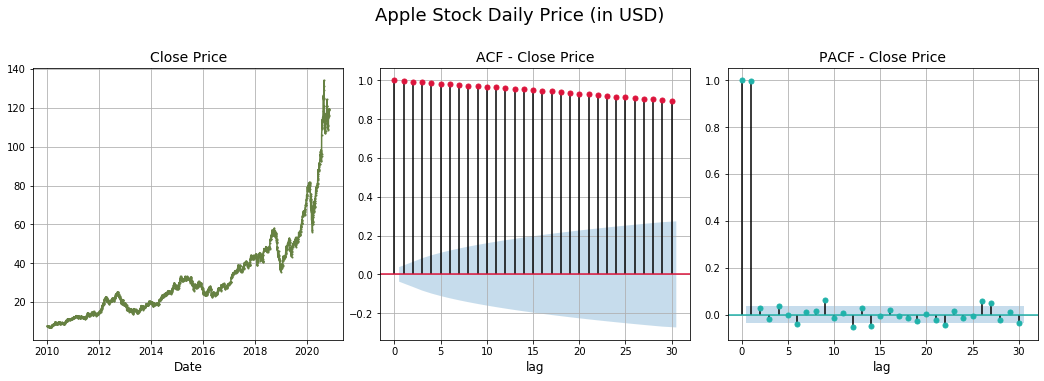

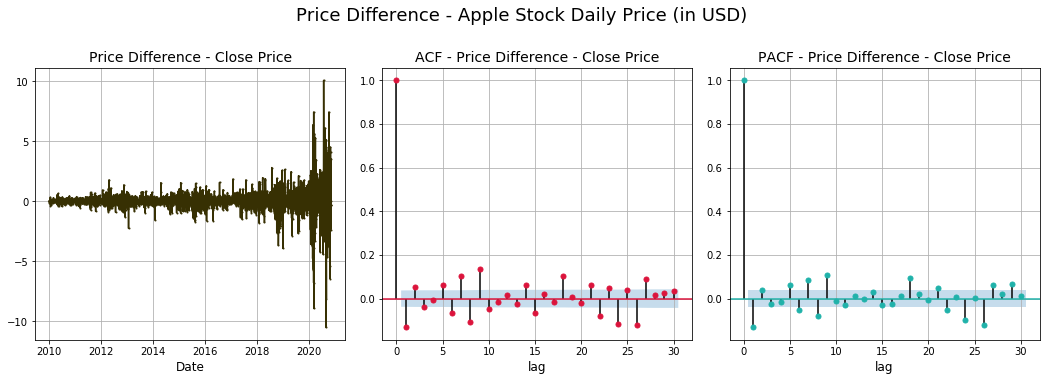

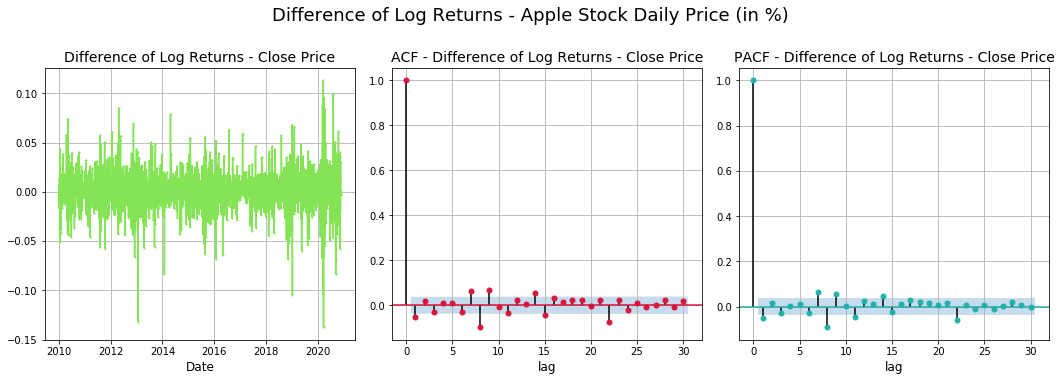


********************************* Processing Nasdaq 100 Index *********************************

Number of observations: 2737 

Nasdaq 100 Index - Summary Statistics

                Open          High           Low         Close
count   2737.000000   2737.000000   2737.000000   2737.000000
mean    4771.854322   4802.454023   4739.002068   4773.293336
std     2401.943180   2421.945209   2380.133090   2402.576967
min     1736.250000   1742.360000   1700.040000   1728.340000
25%     2715.710000   2731.350000   2704.910000   2716.140000
50%     4328.720000   4358.090000   4302.040000   4330.170000
75%     6592.930000   6650.290000   6534.330000   6584.580000
max    12417.450000  12439.480000  12176.180000  12420.540000 

Nasdaq 100 Index - Top Rows

                Open     High      Low    Close
Date                                          
2010-01-04  1882.69  1890.02  1881.63  1886.70
2010-01-05  1887.28  1891.33  1877.52  1888.43
2010-01-06  1887.91  1893.21  1873.90  1878.42 

Nasd

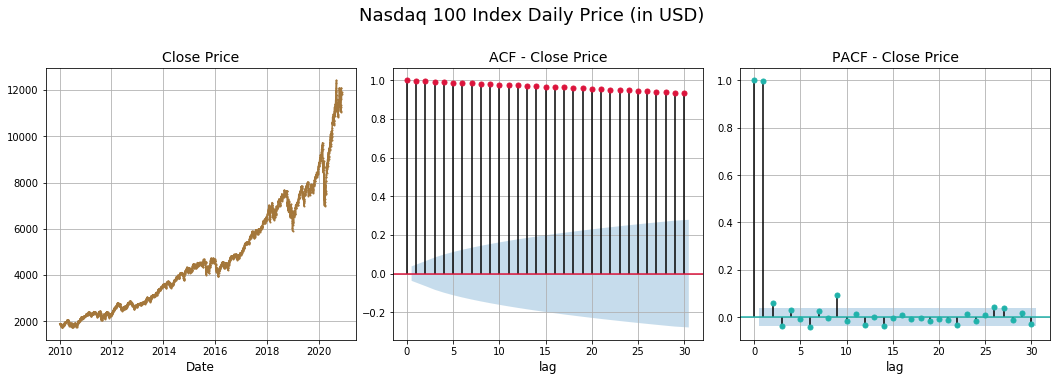

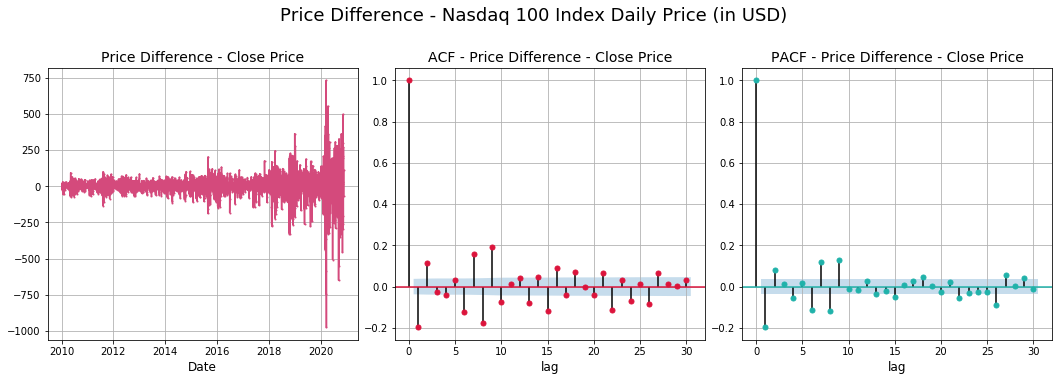

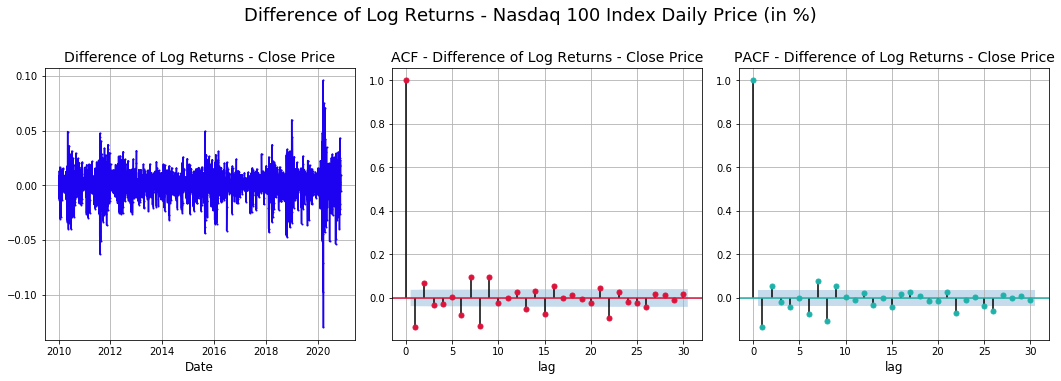

In [24]:
# Display Summary Statistics, Price Charts and ACF & PACF Plots for Price, Price Difference and Log Returns
for security in dfs_price:
    print("\n********************************* Processing", security, "*********************************")

    df = dfs_price[security]
    df_diff = dfs_price_diff[security]
    df_diff_log_returns = dfs_price_diff_log_return[security]
            
    describe_and_peek(df, security)

    # Price
    display_price_acf_pacf(df[['Close']], security, "", "USD")

    # First Order Difference of Price
    display_price_acf_pacf(df_diff[['Close']], security, "Price Difference - ", "USD")

    # First Order Difference of Daily Logarithmic Return
    display_price_acf_pacf(df_diff_log_returns[['Close']], security, "Difference of Log Returns - ", "%")

# Price Prediction using ARIMA an GARCH Models

### Augmented Dicky-Fuller Test with Significance Level - 0.05

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above significance level, then we cannot reject that there is a unit root.

In [25]:
alpha = 0.05

for security in dfs_price_scaled:
    print("\n*************************************** Processing", security, "**************************************\n")

    price_diff = dfs_price_diff[security][price_type]

    # The Augmented Dicky-Fuller Test
    result = adfuller(price_diff)

    # Test Statistic
    print('ADF Statistic: {:.4f}'.format(result[0]))

    # Critical test statistics
    print('5% Critical Value: {:.4f}'.format(result[4]['5%']))

    # p-value
    p_value = result[1]
    print('p-value: {:.4f}'.format(p_value))

    print("Conclusion:", "Reject Null Hypothesis" if p_value < alpha else "Failed to reject Null Hypothesis")
    print("Conclusion:", "Series Might be Stationary" if p_value < alpha else "Series Not Stationary")


*************************************** Processing Apple Stock **************************************

ADF Statistic: -9.0907
5% Critical Value: -2.8626
p-value: 0.0000
Conclusion: Reject Null Hypothesis
Conclusion: Series Might be Stationary

*************************************** Processing Nasdaq 100 Index **************************************

ADF Statistic: -10.3013
5% Critical Value: -2.8626
p-value: 0.0000
Conclusion: Reject Null Hypothesis
Conclusion: Series Might be Stationary


### Auto ARIMA Model (Optimal AR and MA Orders Found in Automated Manner)

In [26]:
# Find optimal orders for SARIMA model
class Auto_Arima():
    def __init__(self, df, start_p=1, start_q=1, max_p=10, max_q=10, seasonal=False, information_criterion='aic'):
        self.df = df
        self.start_p = start_p
        self.start_q = start_q
        self.max_p = max_p
        self.max_q = max_q
        self.seasonal = seasonal
        self.information_criterion = information_criterion

    def arima_results(self):
        return pm.auto_arima(self.df, start_p=self.start_p, start_q=self.start_q, max_p=self.max_p, max_q=self.max_q,
                             seasonal=self.seasonal, information_criterion=self.information_criterion, trace = False,
                             error_action = 'ignore', suppress_warnings=True, stepwise = True, scoring = 'mse')

In [27]:
def auto_arima_model(df, security, price_type):
    # Compute Training and Test Set Sizes
    total_size = len(df)
    test_size = 28
    training_size = total_size - test_size

    train = df[price_type][:-test_size]
    test = df[price_type][-test_size:]

    # Print Training and Test Set Sizes
    print("Auto ARIMA Model: Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)
    
    # Extract datetime for the test data from the dataframe index
    dates = df.tail(test_size).index.format()

    print("Training the model ...")

    # Fit model with auto-arima
    arima_model = Auto_Arima(train)
    model_fit = arima_model.arima_results()
    
    print("Training completed!\n")

    # Print model summary
    print(model_fit.summary())    

    # Plot diagnostics - check residuals
    plot_diag = model_fit.plot_diagnostics(figsize=(16, 10))
    plt.show()
    
    # Use the model to predict for the test data
    predictions = model_fit.predict(n_periods=len(test))

    return "Auto ARIMA", dates, test.values, np.array(predictions), mean_squared_error(test, predictions)

### Manual ARIMA Model  (Optimal AR and MA Orders Found Manually)

In [28]:
def manual_arima_model(df, security, price_type):
    # Compute Training and Test Set Sizes
    total_size = len(df)
    test_size = 28
    training_size = total_size - test_size

    train = df[price_type][:-test_size]
    test = df[price_type][-test_size:]

    # Print Training and Test Set Sizes
    print("Manual ARIMA Model: Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)
    
    # Extract datetime for the test data from the dataframe index
    dates = df.tail(test_size).index.format()

    print("Training the model ...")
    
    # Fit best ARIMA Model
    model = SARIMAX(train.values, order=(7, 1, 7))
    model_fit = model.fit()    
    
    print("Training completed!\n")

    # Print model summary
    print(model_fit.summary())
    
    # Plot diagnostics - check residuals 
    plot_diag = model_fit.plot_diagnostics(figsize=(16, 10))
    plt.show()
    
    # Use the model to predict for the test data
    forecast_results = model_fit.get_forecast(steps=test_size)
    predictions = forecast_results.predicted_mean

    return "Manual ARIMA", dates, test.values, np.array(predictions), mean_squared_error(test, predictions)

### AR-ARCH Model

In [29]:
def ar_arch_model(df_price, df_price_diff, security, price_type):
    # Compute Training and Test Set Sizes
    total_size = len(df)
    test_size = 28
    training_size = total_size - test_size

    price = df_price[price_type]
    price_diff = df_price_diff[price_type]

    # Now let's try forecast on test data
    price_train = price[:-test_size]
    price_test = price[-test_size:]

    price_diff_train = price_diff[:-test_size+1]
    price_diff_test = price_diff[-test_size+1:]
    
    # Print Training and Test Set Sizes
    print("\nAR ARCH Model: Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)
    
    # Extract datetime for the test data from the dataframe index
    dates = df.tail(test_size).index.format()
    
    # Find best lag and p values
    min_mse = 1e6
    best_lags = 0
    best_p = 0
    for lags in range(1, 6):
        for p in range(1, 6):
            model = arch_model(price_diff_train, mean='AR', lags=lags, vol='ARCH', p=p)
            model_fit = model.fit(disp='off')
            forecast_results = model_fit.forecast(horizon=test_size-1)
            price_diff_pred = forecast_results.mean.values[-1, :]
            mse = mean_squared_error(price_diff_test, price_diff_pred)
            if mse < min_mse:
                min_mse = mse
                best_lags = lags
                best_p = p

    print("Best Lag Value:", best_lags, "Best p Value:", best_p)
            
    print("Training the model ...")
    
    model = arch_model(price_diff_train, mean='AR', lags=best_lags, vol='ARCH', p=best_p)
    model_fit = model.fit(disp='off')
    
    print("Training completed!\n")
    
    # Print model summary
    print(model_fit.summary())
    
    # Plot fitted results
    plt.rc("figure", figsize=(10, 7))
    plot_diag = model_fit.plot(annualize='D')
    plt.show()
    
    # Use the model to predict for the test data
    forecast_results = model_fit.forecast(horizon=test_size-1)
    price_diff_pred = forecast_results.mean.values[-1, :]
    
    predictions = [price_test[0]]
    for diff in price_diff_pred:
        predictions.append(predictions[-1] + diff)

    test = price_test.values[1:]
    predictions = np.array(predictions[1:])

    return "AR ARCH", dates[1:], test, predictions, mean_squared_error(test, predictions)

# Price Prediction using LSTM Models

## Common Functions for all the Models

In [30]:
# Given history displays Loss and RMSE curves
def plot_loss_and_rmse(history, title_prefix):
    # Extract loss and accuracy
    loss = history.history['loss']
    rmse = history.history['rmse']

    val_loss = history.history['val_loss']
    val_rmse = history.history['val_rmse']

    epochs = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 8))
    plt.suptitle(title_prefix + "Loss and RMSE", fontsize=18)

    ax[0].plot(epochs, loss, '-o', label='Training Loss')
    ax[0].plot(epochs, val_loss, '-o', color='r', label='Validation Loss')
    ax[0].grid(color='black', which='major', linestyle='dashed')
    ax[0].set_title('Training and Validation Loss', fontsize=18)
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=12)

    ax[1].plot(epochs, rmse, '-o', label='Training RMSE')
    ax[1].plot(epochs, val_rmse, '-o', color='r', label='Validation RMSE')
    ax[1].grid(color='black', which='major', linestyle='dashed')
    ax[1].set_title('Training and Validation RMSE', fontsize=18)
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('RMSE', fontsize=15)
    ax[1].legend(fontsize=12)

    plt.show();
    
# Displays Actual and Predicted prices for given dates
def plot_actual_vs_predicted(dates, actual, predictions, title_prefix, price_type):
    plt.figure(figsize=(21, 8))
    plt.plot(dates, actual, "-o", color='b', label='Actual')
    plt.plot(dates, predictions, "-o", color='r', label='Predicted')
    plt.title(title_prefix + "Actual vs Predicted", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price (USD)", fontsize=15)
    plt.xticks(dates[::6])
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show();

In [31]:
def build_complie_train_model(train_features, train_labels, val_features, val_labels, look_ahead):
    
    # Extract Input Shape
    input_shape = (train_features.shape[1], train_features.shape[2])
    
    # Create the model
    model = Sequential()

    # Add LSTM and Dropout Layers
    model.add(CuDNNLSTM(units=150, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150))
    model.add(Dropout(0.2))

    # Add dense layers
    model.add(Dense(units = look_ahead))

    # Compile the Model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[RootMeanSquaredError(name='rmse')])

    print("Training the model ...")

    # Train the model
    history = model.fit(train_features,
                        train_labels,
                        epochs=100,
                        batch_size=32,
                        validation_data=(val_features, val_labels),
                        verbose=verbose)

    print("Training completed!\n")
    
    return model, history

### Model 1 - Univariate Model

In [32]:
def univariate_model(df, scalers, security, price_type):   
    # Compute Training, Validation and Test Set Sizes
    total_size = len(df)
    total_training_size = int(total_size * 0.95)
    training_size = total_training_size - window_size
    validation_size = int((total_size - total_training_size)*0.8)
    test_size = total_size - total_training_size - validation_size

    # Print Training, Validation and Test Set Sizes
    print("Univariate LSTM Model: Total Size:", total_size,
          "Training Size:", training_size, "Validation Size:", validation_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 1
    title_prefix = security + " " + price_type + " Price - Univariate LSTM Model - "

    # Extract price and scaler for the price type
    price = df[[price_type]].values
    scaler = scalers[price_type]

    # Extract datetime for the test data from the dataframe index
    dates = df.tail(test_size).index.format()

    # Create Training, Validation and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    val_features = []
    val_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price)):
        if i < window_size + training_size:
            train_features.append(price[i-window_size:i, 0])
            train_labels.append(price[i, 0])
        elif i < (window_size + training_size + validation_size):
            val_features.append(price[i-window_size:i, 0])
            val_labels.append(price[i, 0])
        else:
            test_features.append(price[i-window_size:i, 0])
            test_labels.append(price[i, 0])
    
    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    val_features, val_labels = np.array(val_features), np.array(val_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Reshape Training, Validation and Test Feature Sets to fit LSTM input shape
    train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))
    val_features = np.reshape(val_features, (val_features.shape[0], val_features.shape[1], 1))
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    
    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, val_features, val_labels, look_ahead)

    # Save the model
    model.save("lstm_univariate_" + security + '.h5', save_format='tf')
    
    # Display loss and RMSE curves
    plot_loss_and_rmse(history, title_prefix)
    
    # Use the model to predict for the test data
    predictions = model.predict(test_features)

    # Convert the predicted values to origianl scale
    predictions = scaler.inverse_transform(predictions)

    # Convert actual values to origianl scale
    actual = scaler.inverse_transform(test_labels.reshape(-1, 1))

    return "Univariate LSTM", dates, actual, predictions, mean_squared_error(actual, predictions)

### Model 2 - Univariate Multiday Look ahead Model

In [33]:
def univariate_multiday_look_ahead_model(df, scalers, security, price_type):    
    # Compute Training, Validation and Test Set Sizes
    total_size = len(df)
    total_training_size = int(total_size * 0.95)
    training_size = total_training_size - window_size
    validation_size = int((total_size - total_training_size)*0.8)
    test_size = total_size - total_training_size - validation_size

    # Print Training, Validation and Test Set Sizes
    print("\nUnivariate MultiDay Look ahead LSTM Model: Total Size:", total_size,
          "Training Size:", training_size, "Validation Size:", validation_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 3
    title_prefix = security + " " + price_type + " Price - Univariate Multiday Look ahead LSTM Model - "

    # Extract price and scaler for the price type
    price = df[[price_type]].values
    scaler = scalers[price_type]
    
    # Extract datetime for the test data from the dataframe index
    all_dates = df.tail(test_size).index.format()

    # Create Training, Validation and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    val_features = []
    val_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price) - look_ahead + 1):  
        if i < window_size + training_size:
            train_features.append(price[i-window_size:i, 0])
            train_labels.append(price[i:i+look_ahead, 0])
        elif i < (window_size + training_size + validation_size):
            val_features.append(price[i-window_size:i, 0])
            val_labels.append(price[i:i+look_ahead, 0])
        else:
            test_features.append(price[i-window_size:i, 0])
            test_labels.append(price[i:i+look_ahead, 0])
    
    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    val_features, val_labels = np.array(val_features), np.array(val_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Reshape data to fit LSTM input shape
    train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))
    val_features = np.reshape(val_features, (val_features.shape[0], val_features.shape[1], 1))
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    
    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, val_features, val_labels, look_ahead)

    # Save the model
    model.save("lstm_univariate_multiday_look_ahead_" + security + '.h5', save_format='tf')
    
    # Display loss and RMSE curves
    plot_loss_and_rmse(history, title_prefix)
    
    # Use the model to predict for the test data
    predictions = model.predict(test_features)

    # Convert the predicted values to origianl scale
    predictions = scaler.inverse_transform(predictions)

    # Convert actual values to origianl scale
    actual = scaler.inverse_transform(test_labels)    

    model_names = np.empty(look_ahead, dtype=object)
    dates = np.empty((test_size-look_ahead+1, look_ahead), dtype=object)
    mse = np.empty(look_ahead)

    for i in range(look_ahead):
        model_names[i] = "Univariate: Lahead-" + str(i+1)        
        dates[:, i] = np.array(all_dates[i:i+test_size-look_ahead+1])
        mse[i] = mean_squared_error(actual[:, i], predictions[:, i])
    
    return model_names, dates, actual, predictions, mse

### Model 3 - Multivariate Model

In [34]:
def multivariate_model(df, scalers, security, price_type):
    # Compute Training, Validation and Test Set Sizes
    total_size = len(df)
    total_training_size = int(total_size * 0.95)
    training_size = total_training_size - window_size
    validation_size = int((total_size - total_training_size)*0.8)
    test_size = total_size - total_training_size - validation_size

    # Print Training, Validation and Test Set Sizes
    print("Multivariate LSTM Model: Total Size:", total_size,
          "Training Size:", training_size, "Validation Size:", validation_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 1
    title_prefix = security + " " + price_type + " Price - Multivariate LSTM Model - "

    # Extract price and scaler for the price type
    price_all = df.values
    price = df[[price_type]].values
    scaler = scalers[price_type]

    # Extract datetime for the test data from the dataframe index
    dates = df.tail(test_size).index.format()

    # Create Training, Validation and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    val_features = []
    val_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price)):
        if i < window_size + training_size:
            train_features.append(price_all[i-window_size:i, :])
            train_labels.append(price[i, 0])
        elif i < (window_size + training_size + validation_size):
            val_features.append(price_all[i-window_size:i, :])
            val_labels.append(price[i, 0])
        else:
            test_features.append(price_all[i-window_size:i, :])
            test_labels.append(price[i, 0])

    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    val_features, val_labels = np.array(val_features), np.array(val_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, val_features, val_labels, look_ahead)

    # Save the model
    model.save("lstm_multivariate_" + security + '.h5', save_format='tf')
    
    # Display loss and rmse curves
    plot_loss_and_rmse(history, title_prefix)
    
    # Use the model to predict for the test data
    predictions = model.predict(test_features)

    # Convert the predicted values to origianl scale
    predictions = scaler.inverse_transform(predictions)

    # Convert actual values to origianl scale
    actual = scaler.inverse_transform(test_labels.reshape(-1, 1))

    return "Multivariate LSTM", dates, actual, predictions, mean_squared_error(actual, predictions)

# Run all the models and display results

In [35]:
# Number of past values to be used for prediction
window_size = 60


*************************************** Processing Apple Stock **************************************

Auto ARIMA Model: Total Size: 2737 Training Size: 2709 Test Size: 28
Training the model ...
Training completed!

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2709
Model:               SARIMAX(9, 2, 2)   Log Likelihood               -3327.886
Date:                Wed, 09 Dec 2020   AIC                           6681.773
Time:                        05:26:06   BIC                           6758.520
Sample:                             0   HQIC                          6709.523
                               - 2709                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

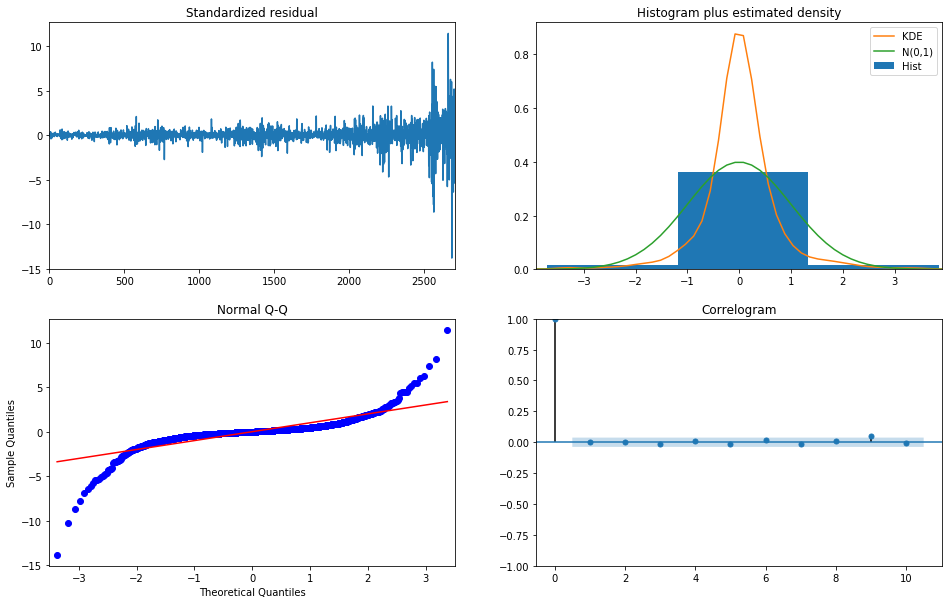

Manual ARIMA Model: Total Size: 2737 Training Size: 2709 Test Size: 28
Training the model ...


C:\Users\Aqua Guy\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Training completed!

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2709
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -3294.648
Date:                Wed, 09 Dec 2020   AIC                           6619.296
Time:                        05:26:14   BIC                           6707.855
Sample:                             0   HQIC                          6651.317
                               - 2709                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0119      0.032    -62.464      0.000      -2.075      -1.949
ar.L2         -2.1921      0.060    -36.641      0.000      -2.309      -2.075
ar.L3         -0.7552      0.05

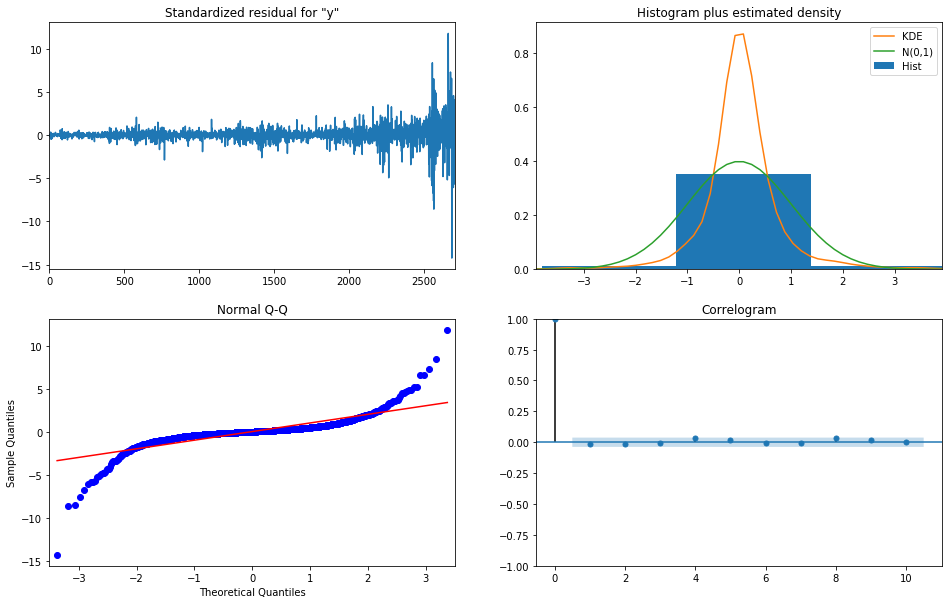


AR ARCH Model: Total Size: 2737 Training Size: 2709 Test Size: 28
Best Lag Value: 5 Best p Value: 4
Training the model ...
Training completed!

                           AR - ARCH Model Results                            
Dep. Variable:                  Close   R-squared:                      -0.031
Mean Model:                        AR   Adj. R-squared:                 -0.033
Vol Model:                       ARCH   Log-Likelihood:               -1796.29
Distribution:                  Normal   AIC:                           3614.58
Method:            Maximum Likelihood   BIC:                           3679.51
                                        No. Observations:                 2704
Date:                Wed, Dec 09 2020   Df Residuals:                     2693
Time:                        05:26:17   Df Model:                           11
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% C

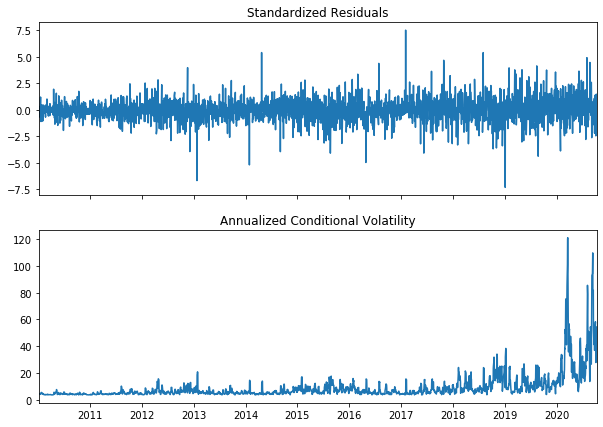

Univariate LSTM Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



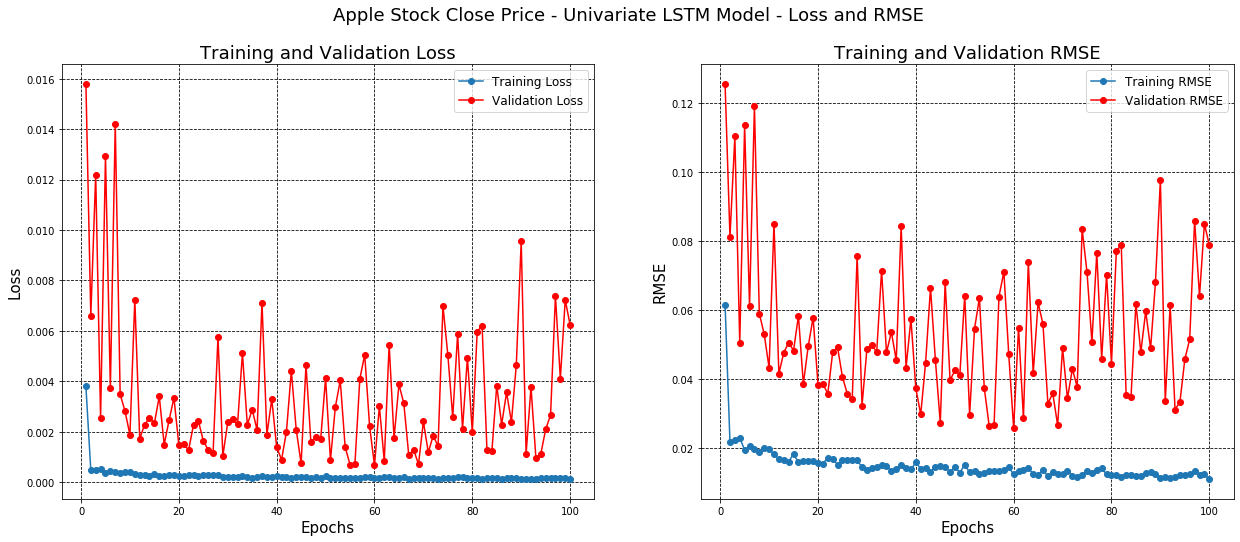


Univariate MultiDay Look ahead LSTM Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



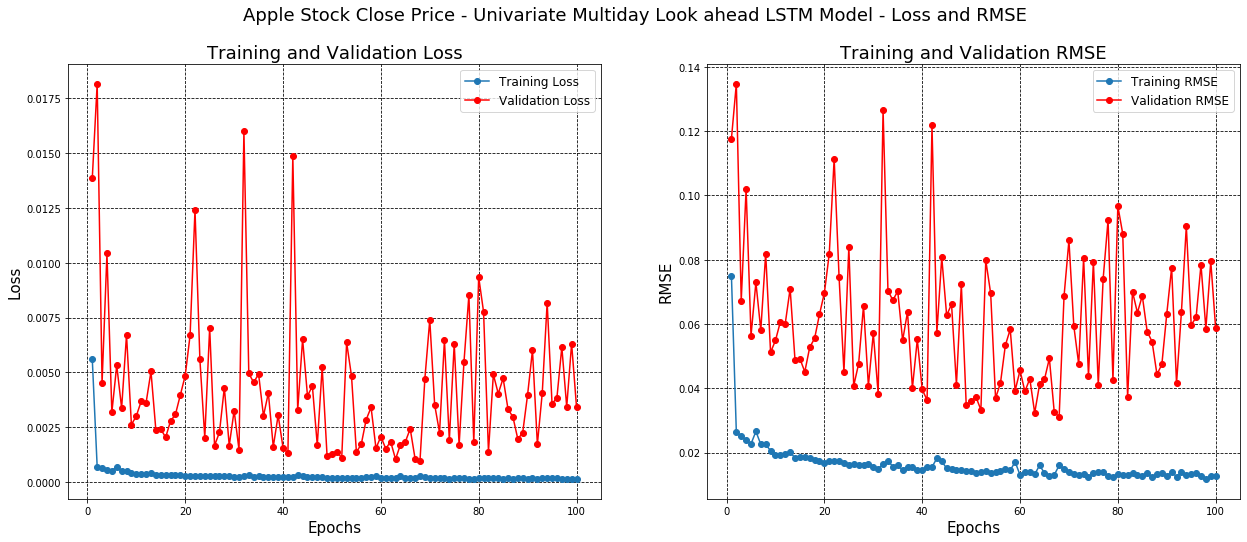

Multivariate LSTM Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



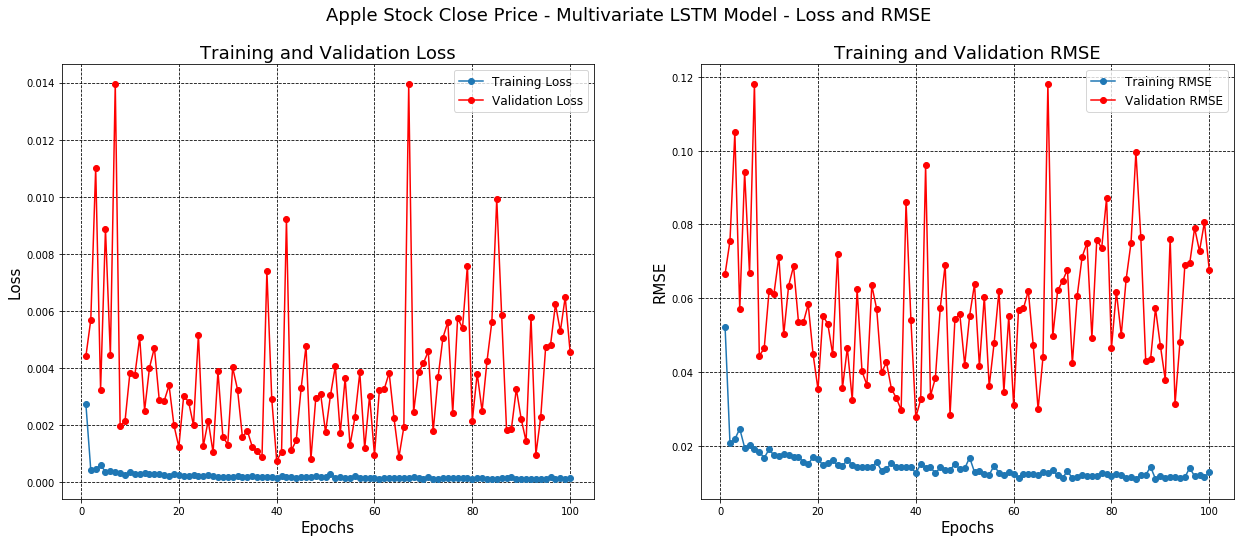


*************************************** Processing Nasdaq 100 Index **************************************

Auto ARIMA Model: Total Size: 2737 Training Size: 2709 Test Size: 28
Training the model ...
Training completed!

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2709
Model:               SARIMAX(9, 1, 0)   Log Likelihood              -15412.565
Date:                Wed, 09 Dec 2020   AIC                          30847.130
Time:                        05:39:43   BIC                          30912.074
Sample:                             0   HQIC                         30870.612
                               - 2709                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

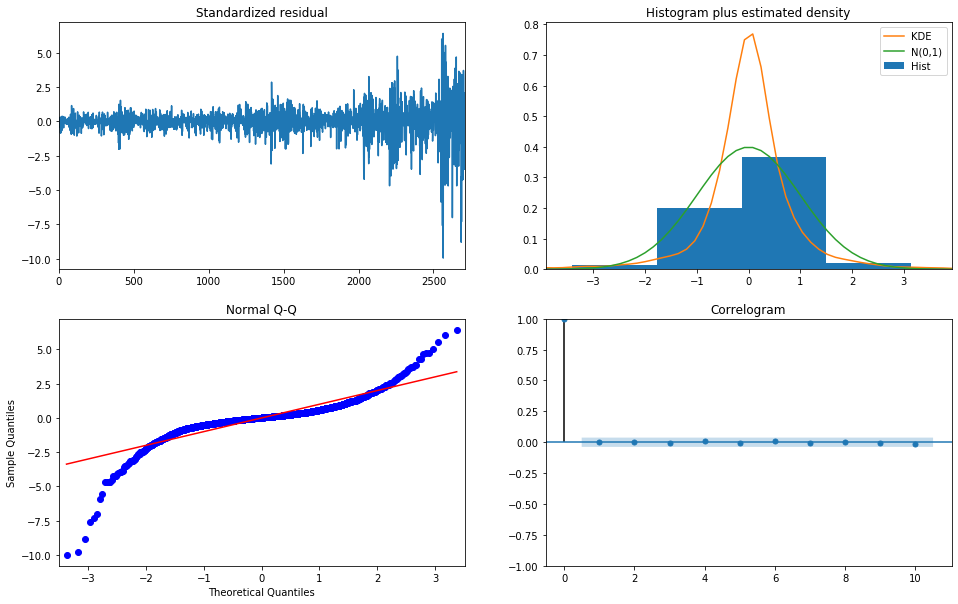

Manual ARIMA Model: Total Size: 2737 Training Size: 2709 Test Size: 28
Training the model ...


C:\Users\Aqua Guy\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Training completed!

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2709
Model:               SARIMAX(7, 1, 7)   Log Likelihood              -15408.308
Date:                Wed, 09 Dec 2020   AIC                          30846.617
Time:                        05:39:48   BIC                          30935.176
Sample:                             0   HQIC                         30878.638
                               - 2709                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8046      8.219     -0.098      0.922     -16.914      15.305
ar.L2          0.1548      9.077      0.017      0.986     -17.637      17.946
ar.L3          0.4240      1.44

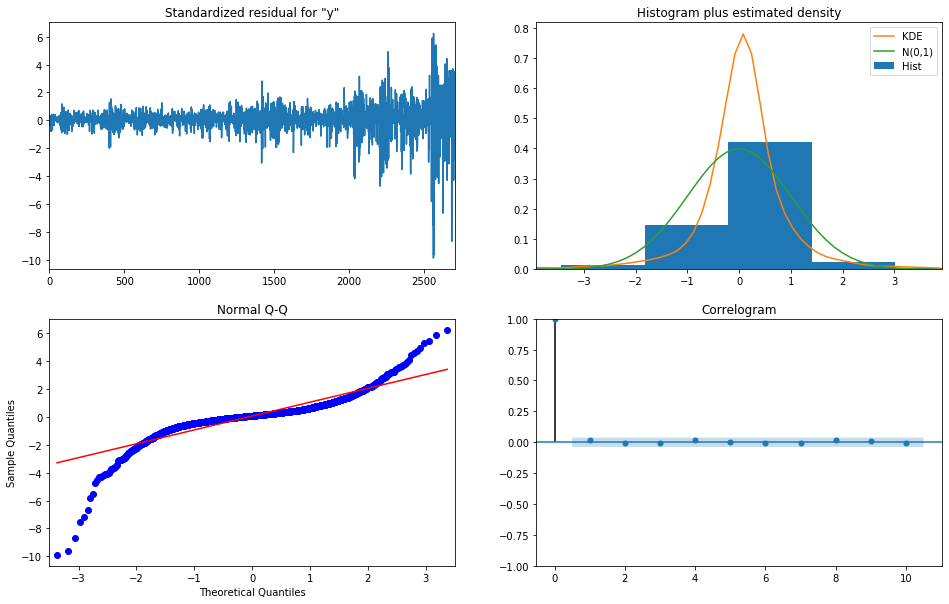


AR ARCH Model: Total Size: 2737 Training Size: 2709 Test Size: 28
Best Lag Value: 4 Best p Value: 4
Training the model ...
Training completed!

                           AR - ARCH Model Results                            
Dep. Variable:                  Close   R-squared:                       0.006
Mean Model:                        AR   Adj. R-squared:                  0.005
Vol Model:                       ARCH   Log-Likelihood:               -14196.3
Distribution:                  Normal   AIC:                           28412.5
Method:            Maximum Likelihood   BIC:                           28471.6
                                        No. Observations:                 2705
Date:                Wed, Dec 09 2020   Df Residuals:                     2695
Time:                        05:39:51   Df Model:                           10
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Con

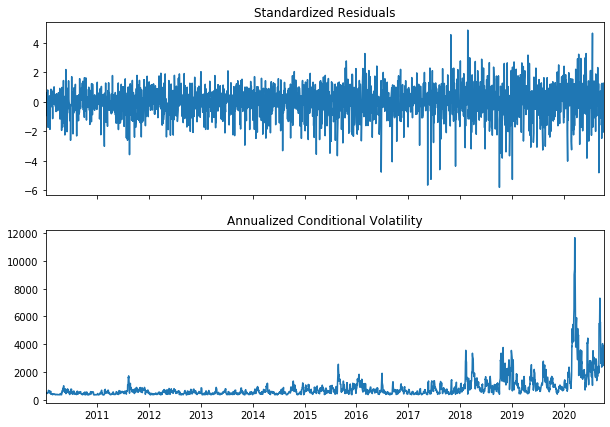

Univariate LSTM Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



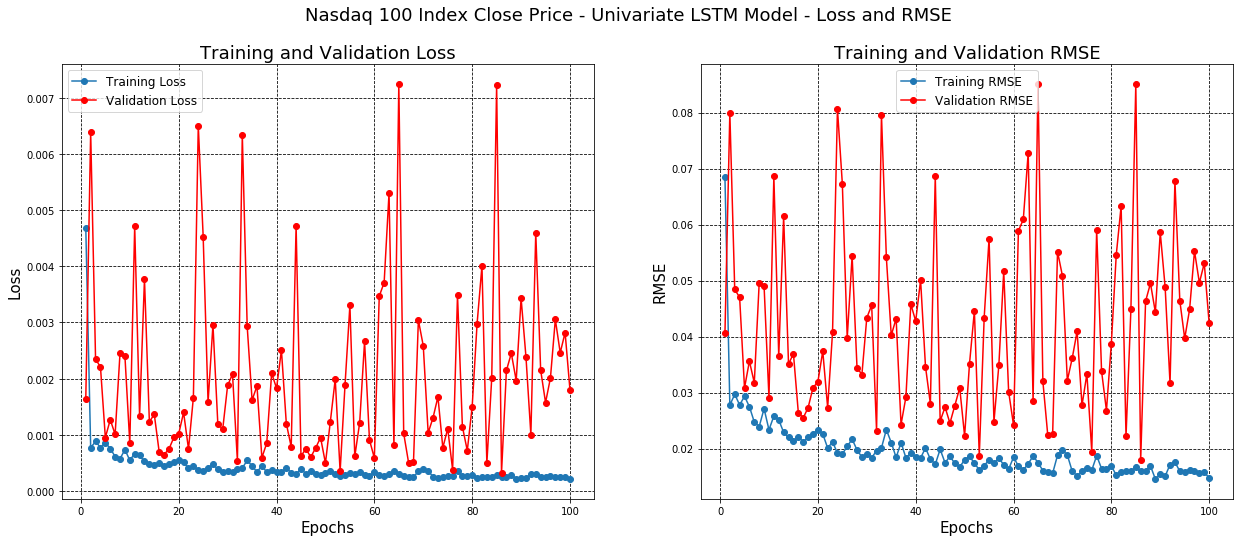


Univariate MultiDay Look ahead LSTM Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



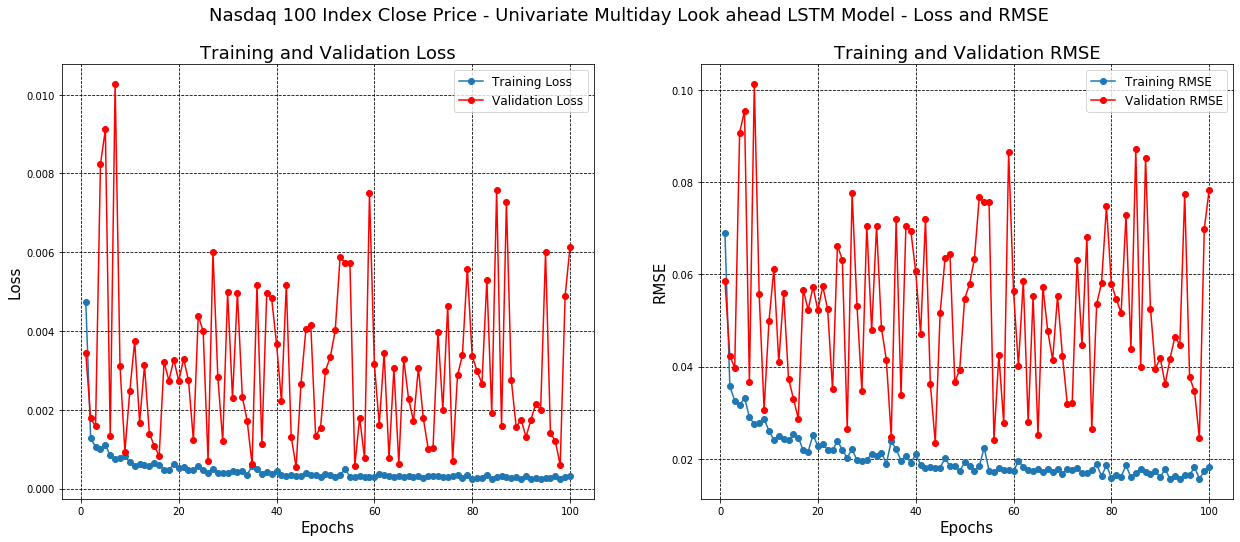

Multivariate LSTM Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



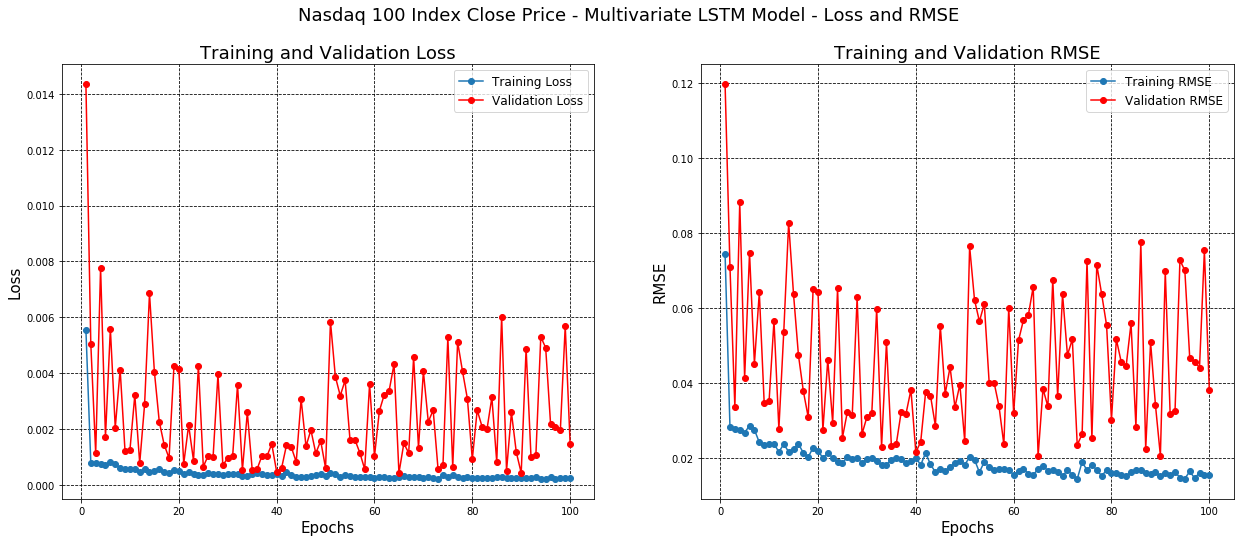

In [36]:
# Build and Predict Using all the Models
results = {}
for security in dfs_price_scaled:
    print("\n*************************************** Processing", security, "**************************************\n")
    security_results = {}

    price = dfs_price[security]
    price_diff = dfs_price_diff[security]
    
    price_scaled = dfs_price_scaled[security]    
    scaler = scalers[security]
    
    model, dates, actual, predictions, mse = auto_arima_model(price, security, price_type)
    security_results[model] = dates, actual, predictions, mse
    
    model, dates, actual, predictions, mse = manual_arima_model(price, security, price_type)
    security_results[model] = dates, actual, predictions, mse
    
    model, dates, actual, predictions, mse = ar_arch_model(price, price_diff, security, price_type)
    security_results[model] = dates, actual, predictions, mse   

    model, dates, actual, predictions, mse = univariate_model(price_scaled, scaler, security, price_type)
    security_results[model] = dates, actual, predictions, mse

    model, dates, actual, predictions, mse  = univariate_multiday_look_ahead_model(price_scaled, scaler, security, price_type)
    for i in range(len(model)):
        security_results[model[i]] = dates[:, i], actual[:, i], predictions[:, i], mse[i]

    model, dates, actual, predictions, mse  = multivariate_model(price_scaled, scaler, security, price_type)
    security_results[model] = dates, actual, predictions, mse

    results[security] = security_results

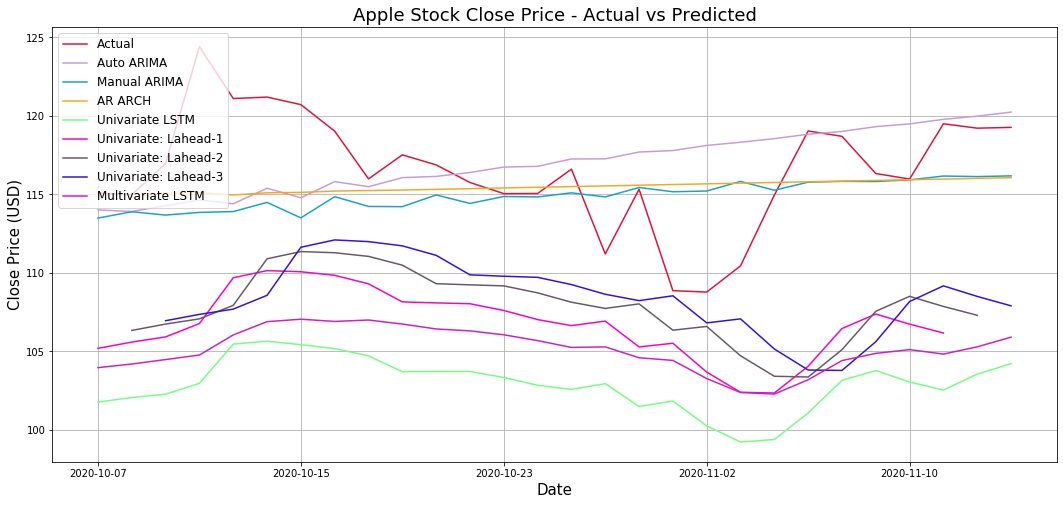

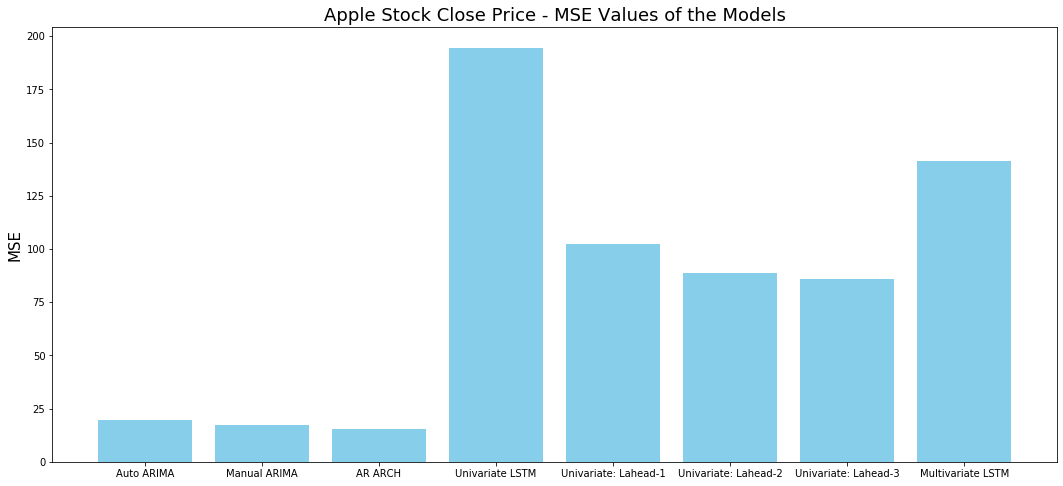

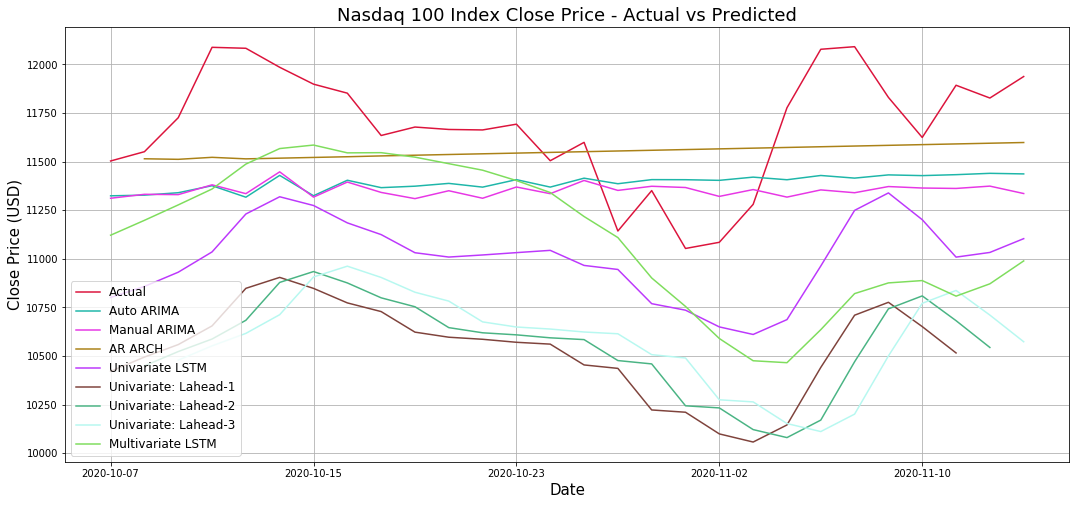

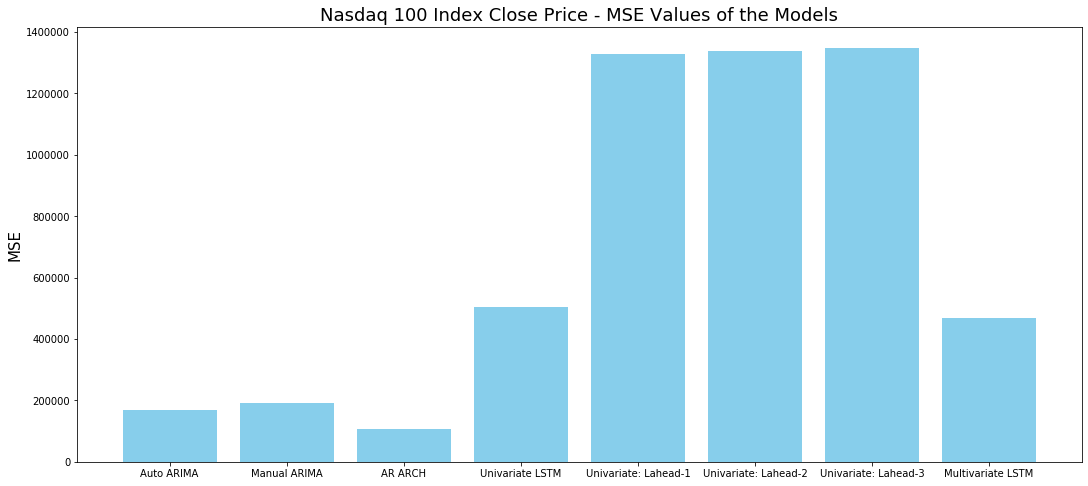

In [37]:
for security, security_results in results.items():
    model_list = []
    mse_list = []
    
    plt.figure(figsize=(18, 8))
    for model, model_results in security_results.items():
        dates, actual, predictions, mse = model_results
        model_list.append(model)
        mse_list.append(mse)

        if model == 'Auto ARIMA':
            plt.plot(dates, actual, "-", color='crimson', label='Actual')
        plt.plot(dates, predictions, "-", color=np.random.rand(3,), label=model)

    plt.title(security + " " + price_type + " Price - Actual vs Predicted", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price (USD)", fontsize=15)
    plt.xticks(dates[::6])    
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(18, 8))
    plt.bar(model_list, mse_list, color='skyblue')  
    plt.title(security + " " + price_type + " Price - MSE Values of the Models", fontsize=18)
    plt.ylabel("MSE", fontsize=15)
    plt.show();